In [25]:
# Librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sksurv.metrics import concordance_index_ipcw
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
from lifelines import KaplanMeierFitter

In [16]:
# Cargar el archivo CSV 
all_data = pd.read_csv('Dataset.csv')

# Mostrar la información del DataFrame
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9712 entries, 0 to 9711
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient ID                 8799 non-null   object 
 1   Age at Diagnosis           8332 non-null   float64
 2   Cancer Type                9712 non-null   object 
 3   Cancer Type Detailed       9712 non-null   object 
 4   Mutation Count             8408 non-null   float64
 5   Overall Survival (Months)  9712 non-null   float64
 6   Overall Survival Status    9712 non-null   int64  
 7   Gender                     9710 non-null   object 
 8   Ethnicity                  3814 non-null   object 
 9   Race                       4927 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 758.9+ KB


In [17]:
# Imputar 'Unknown' en Ethnicity y Race si hay valores nulos
all_data['Ethnicity'] = all_data['Ethnicity'].fillna('Unknown')
all_data['Race'] = all_data['Race'].fillna('Unknown')

# Filtrar solo columnas que vamos a usar
selected_columns = [
    'Age at Diagnosis', 'Cancer Type', 'Cancer Type Detailed', 'Mutation Count',
    'Gender', 'Ethnicity', 'Race', 'Overall Survival (Months)', 'Overall Survival Status'
]
df = all_data[selected_columns].copy()

# Eliminar filas que todavía tengan valores nulos en las columnas seleccionadas
df = df.dropna()

# Codificación de variables categóricas

# Convertimos las variables categóricas en codificación numérica (One-hot encoding)
df_encoded = pd.get_dummies(df, columns=['Cancer Type', 'Cancer Type Detailed', 'Gender', 'Ethnicity', 'Race'], drop_first=True)

# Preparar datos para RSF

# Creamos la variable 'y' (Survival Object)
y = Surv.from_dataframe("Overall Survival Status", "Overall Survival (Months)", df_encoded)

# Eliminamos las columnas de 'Overall Survival' del X
X = df_encoded.drop(['Overall Survival (Months)', 'Overall Survival Status'], axis=1)

# Split train-test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento de Random Survival Forest

rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rsf.fit(X_train, y_train)

# Evaluación rápida (por ejemplo, C-index en test)

c_index = rsf.score(X_test, y_test)
print(f"C-index en test: {c_index:.4f}")


C-index en test: 0.7031


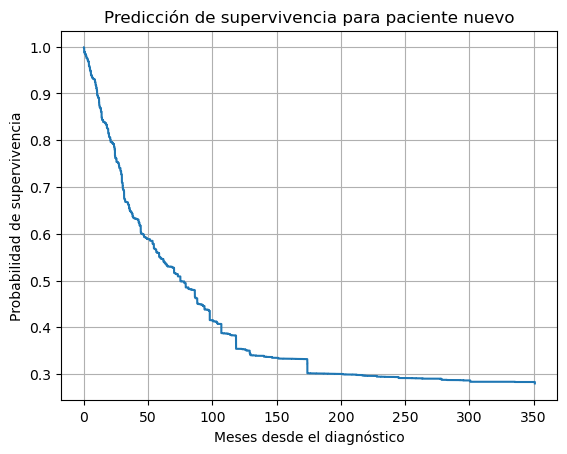

In [18]:
# Ejemplo: predicción para un paciente nuevo

# Suponiendo que queremos predecir un paciente nuevo:
nuevo_paciente = {
    'Age at Diagnosis': 60,
    'Mutation Count': 150,
    'Cancer Type_Lung Cancer': 1,
    'Cancer Type_Breast Cancer': 0,
    'Cancer Type_Colon Cancer': 0,
    'Cancer Type Detailed_Adenocarcinoma': 1,
    'Gender_Male': 1,
    'Ethnicity_Unknown': 1,
    'Race_White': 1,
    # Las demás columnas de one-hot encoding las rellenamos con 0 si no están en el paciente
}

# Creamos un DataFrame del paciente
nuevo_paciente_df = pd.DataFrame([nuevo_paciente])

# Añadimos columnas faltantes que pudiera necesitar el modelo
for col in X.columns:
    if col not in nuevo_paciente_df.columns:
        nuevo_paciente_df[col] = 0  # Asignamos 0 a las variables no especificadas

# Aseguramos el mismo orden de columnas
nuevo_paciente_df = nuevo_paciente_df[X.columns]

# Predecimos
pred_surv_func = rsf.predict_survival_function(nuevo_paciente_df)

# Plot o visualización rápida

for fn in pred_surv_func:
    plt.step(fn.x, fn.y, where="post")
plt.xlabel("Meses desde el diagnóstico")
plt.ylabel("Probabilidad de supervivencia")
plt.title("Predicción de supervivencia para paciente nuevo")
plt.grid(True)
plt.show()

In [19]:
# Predecir la función de supervivencia
pred_surv = rsf.predict_survival_function(nuevo_paciente_df)

# pred_surv es una lista, aunque tengamos solo un paciente
fn = pred_surv[0]

# Estimación manual de la esperanza de vida: área bajo la curva (integral)
# Como son datos discretos, aproximamos sumando trapecios

esperanza_vida_meses = np.trapz(fn.y, fn.x)

print(f"Esperanza de vida estimada: {esperanza_vida_meses:.1f} meses")


Esperanza de vida estimada: 141.1 meses


In [20]:
# Evaluación del modelo (C-Index)
c_index_train = rsf.score(X_train, y_train)
c_index_test = rsf.score(X_test, y_test)
print(f"C-index en entrenamiento: {c_index_train:.4f}")
print(f"C-index en prueba: {c_index_test:.4f}")


C-index en entrenamiento: 0.7294
C-index en prueba: 0.7031


### Validación cruzada

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, test_idx in kf.split(X):
    rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10,
                                min_samples_leaf=15, max_features="sqrt",
                                n_jobs=-1, random_state=42)
    rsf.fit(X.iloc[train_idx], y[train_idx])
    pred = rsf.predict(X.iloc[test_idx])
    score = concordance_index_censored(y[test_idx]['Overall Survival Status'], y[test_idx]['Overall Survival (Months)'], pred)[0]
    scores.append(score)

print(f"C-index medio (CV): {np.mean(scores):.4f}")


C-index medio (CV): 0.6916


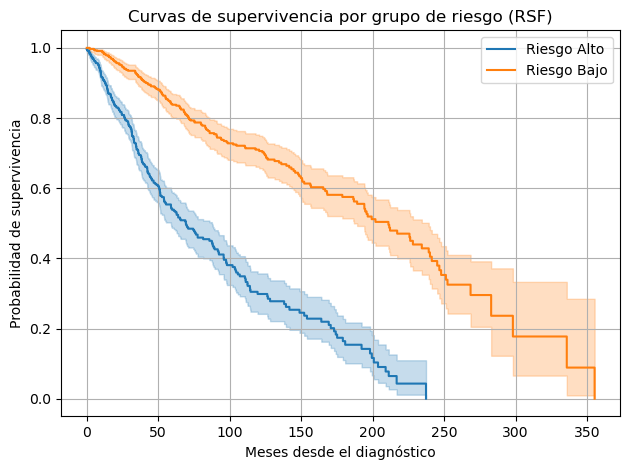

In [26]:
# Obtener riesgo estimado (inverso del tiempo esperado de supervivencia)
riesgo = -np.array([np.trapz(fn.y, fn.x) for fn in rsf.predict_survival_function(X_test)])

# Dividir pacientes en alto/bajo riesgo según la mediana
umbral = np.median(riesgo)
grupo_riesgo = ['Alto' if r >= umbral else 'Bajo' for r in riesgo]

# Reconstruir dataset con duración y evento
duraciones = [y[1] for y in y_test]
eventos = [y[0] for y in y_test]

# Plot Kaplan-Meier por grupo
kmf = KaplanMeierFitter()
plt.figure()

for grupo in ['Alto', 'Bajo']:
    mask = [g == grupo for g in grupo_riesgo]
    kmf.fit(durations=np.array(duraciones)[mask],
            event_observed=np.array(eventos)[mask],
            label=f'Riesgo {grupo}')
    kmf.plot_survival_function()

plt.title("Curvas de supervivencia por grupo de riesgo (RSF)")
plt.xlabel("Meses desde el diagnóstico")
plt.ylabel("Probabilidad de supervivencia")
plt.grid(True)
plt.tight_layout()
plt.show()